0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
4590.395567178726
0.2


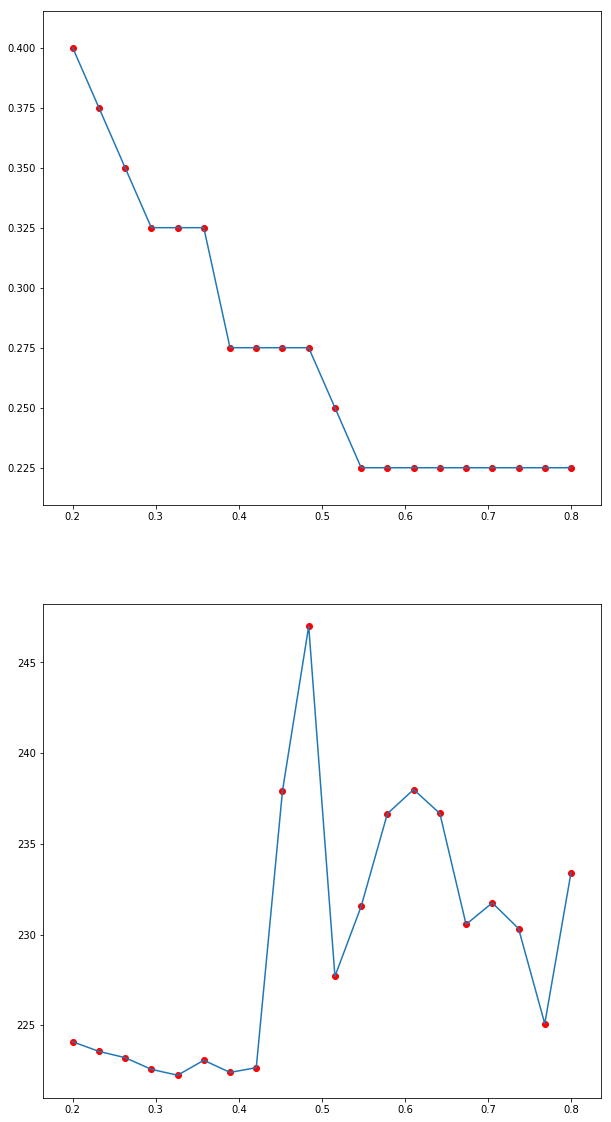

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pylab
import time


def uniform(ratio, k, eps=0.1):
    a = int(np.sqrt(k))
    b = k // a + (k % a != 0)
    while abs(a / b - ratio) >= eps:
        if a == 1:
            break
        a -= 1
        b = k // a + (k % a != 0)
    return a, b


def dist(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)


def strat_of_init(matr, strat="uniform", k=2, show_work=-1, eps=0.0001):
    if k == 0:
        print("k == 0!!!!")
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    xc = np.zeros(k)
    yc = np.zeros(k)
    
    if strat == "random":
        xc = np.random.rand(k) * (x.max() - x.min()) + x.min()
        yc = np.random.rand(k) * (y.max() - y.min()) + y.min()
        if show_work >= 0:
            pylab.figure(show_work)
            plt.scatter(xc, yc, marker = "*", c = "r")
        return xc, yc
    if strat == "choice":
        r = np.random.choice(length, k, replace = False)
        xc = x[r]
        yc = y[r]
        if show_work >= 0:
            pylab.figure(show_work)
            plt.scatter(xc, yc, marker = "*", c = "r")
        return xc, yc
    if strat == "plusplus":
        r = np.random.choice(k, replace = False)
        xc[0] = x[r]
        yc[0] = y[r]
        for ready in range(k - 1):
            dx2 = np.zeros(length)
            sumdx2 = 0
            for i in range(length):
                dx2[i] = dist(xc[ready], yc[ready], x[i], y[i])
                for j in range(ready):
                    dx2[i] = min(dx2[i], dist(xc[j], yc[j], x[i], y[i]))
                sumdx2 += dx2[i]
            sumdx2 *= np.random.rand()
            sumdx = 0
            for i in range(length):
                sumdx += dx2[i]
                if sumdx > sumdx2:
                    xc[ready + 1] = x[i]
                    yc[ready + 1] = y[i]
                    break
        return xc, yc
    x_len = x.max()-x.min()
    y_len = y.max()-y.min()
    uni_x, uni_y = uniform(x_len/y_len, k, eps=eps)
    units = np.random.choice(uni_x * uni_y, k, replace=False)
    xc = np.zeros(k)
    yc = np.zeros(k)
    for i in range(k):
        xc[i] = x.min() + x_len / (2 * uni_x) + (units[i] % uni_x) * x_len / uni_x
        yc[i] = y.min() + y_len / (2 * uni_y) + (units[i] % uni_y) * y_len / uni_y
    xline, yline = 0, 0
    for i in range(uni_x + 1):
        xline = x.min() + i * x_len / uni_x
    for i in range(uni_y + 1):
        yline = y.min() + i * y_len / uni_y
    if show_work >= 0:
        pylab.figure(show_work)
        plt.scatter(xc, yc, marker="*", c="r")
        plt.plot([xline, xline], [y.min(), y.max()])
        plt.plot([x.min(), x.max()], [yline, yline])
    return xc, yc


def filter_by_clust(a, i, length):
    return list(filter(lambda q: a[q] == i, range(length)))


def KMeans4(matr, k=2, seed=0, eps=0.0001, limit_of_rec=500, show_work=-1, strat = "plusplus"):
    np.random.seed(seed)
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    
    xc, yc = strat_of_init(matr, strat = strat, k = k, show_work=show_work)
    matr = np.concatenate([x, y, np.random.randint(0, k, length, dtype = int)])
    matr = matr.reshape(3, length).T
    limit = limit_of_rec
    while True:
        limit -= 1
        if limit == 0:
            if show_work >= 0:
                print("Calculated with the achievement of the limit number of iterations: ", limit_of_rec)
            break
        for i in range(length):
            clast = k - 1
            dist_to_clast = dist(matr[i][0], matr[i][1], xc[k - 1], yc[k - 1])
            for j in range(k - 1):
                cur_dist = dist(matr[i][0], matr[i][1], xc[j], yc[j])
                if cur_dist < dist_to_clast:
                    dist_to_clast = cur_dist
                    clast = j
            matr[i][2] = clast
        sums = 0
        for i in range(k):
            fil = filter_by_clust(matr[:, 2], i, length)
            if len(fil) == 0:
                sums = eps + 1
                r = np.random.randint(length)
                xc[i] = x[r]
                yc[i] = y[r]
            else:
                xcc = xc[i]
                ycc = yc[i]
                xc[i] = np.mean(x[fil])
                yc[i] = np.mean(y[fil])
                sums += dist(xc[i], yc[i], xcc, ycc)
        if sums < eps:
            if show_work >= 0:
                print("Calculated with given accuracy, number of iterations =", limit_of_rec - limit)
            break
    if show_work >= 0:
        pylab.figure(show_work)
        plt.scatter(xc, yc, marker = "v", c = "black")
    return matr[:, 2], xc, yc


def best_K(matr, k_max=0, show_work=-1, eps=0.15, d_eps=0.0001):
    x = np.asarray(matr[:, 0])
    y = np.asarray(matr[:, 1])
    length = len(x)
    if k_max == 0:
        k_max = int(pow(length, 1/3)) + 2
    if k_max < 2:
        k_max = 3
    arr = np.array(range(k_max - 2)) + 2
    inter_max = np.zeros(k_max - 2)
    exter_min = np.zeros(k_max - 2)
    
    for e in range(k_max - 2):
        if arr[e] == 0:
            print("Oh no!")
        a, xc, yc = KMeans4(matr, k = arr[e])
        flag = True
        for i in range(arr[e]):
            j = i + 1
            while j < arr[e]:
                d = dist(xc[i], yc[i], xc[j], yc[j])
                if flag:
                    exter_min[e] = d
                    flag = False
                exter_min[e] = min(exter_min[e], d)
                j += 1
            fil = filter_by_clust(a, i, length)
            for j in fil:
                d = dist(xc[i], yc[i], x[j], y[j])
                inter_max[e] = max(inter_max[e], d)
    out = np.diff(exter_min/inter_max)
    arr = arr[:-1]
    f = list(filter(lambda i: abs(out[i]) < eps, range(len(out))))
    while len(f)==0:
        eps += d_eps
        f = list(filter(lambda i: abs(out[i]) < eps, range(len(out))))
    if show_work >= 0:
        pylab.figure(show_work, figsize = (10, 10))
        plt.plot(arr, out)
        plt.scatter(arr, out, c = 'y')
        plt.xlabel("Количество кластеров")
        plt.ylabel("Отношение \nминимального внешнекластерного \nи максимального \nвнутрикластерного расстояний")
    return arr[f[0] - 1]


n = [1200, 1600, 900, 1400]
k = [5, 4, 3, 2]

length = len(n)
while len(k) < length:
    k.append(2)
number_of_tests = 10
qq = 20
eps = np.linspace(0.2, 0.8, qq)
prob = np.zeros(qq)
times = np.zeros(qq)
for p in range(qq):
    success = 0
    all_time = time.time()
    print(p)
    for j in range(length):
        for i in range(number_of_tests):
            x, y = make_blobs(n_samples = n[j], n_features = 2, centers = k[j], random_state = i)
            k1 = best_K(x, eps = eps[p])
            if k1 == k[j]:
                success += 1
    prob[p] = success/(number_of_tests * length)
    times[p] = time.time() - all_time

print(sum(times))
print(eps[prob.argmax()])
pylab.figure(0, figsize=(10, 20))
pylab.subplot(211)
plt.scatter(eps, prob, c="r")
plt.plot(eps, prob)
pylab.subplot(212)
plt.scatter(eps, times, c="r")
plt.plot(eps, times)
    
plt.show()